# Análisis de Siniestros 


Creación y comparación de modelos de regresión lineal, `gamma` y `normal`. Para el análisis de siniestros automovilísticos y la posterior realización de seguros.

## Carga de Datos 

In [1]:
import pandas as pd
import numpy as np
import plotly as px
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from typing import Optional, Tuple, Any


In [2]:
# Importar datos
url = 'https://www.ime.usp.br/~giapaula/claims.txt'
data = pd.read_csv(url, delim_whitespace=True, header=None)
data.columns = ['valorv' , 'expos', 'nsinistros', 'csinistros', 'tipov', 'idadev', 'sexoc', 'areac', 'idadec']
# Creación de nueva variable
data['cmsinistros'] = data['csinistros']/data['nsinistros']



C:\Users\BlackMarrow PC\AppData\Local\Temp\ipykernel_11172\2859936270.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(url, delim_whitespace=True, header=None)


In [3]:
data.head()

,valorv,expos,nsinistros,csinistros,tipov,idadev,sexoc,areac,idadec,cmsinistros
0,1.66,0.484600,1,669.509999,SEDAN,3,M,B,6,669.509999
1,1.51,0.993840,1,806.609999,SEDAN,3,F,F,4,806.609999
2,0.76,0.539357,1,401.805451,HBACK,3,M,C,4,401.805451
3,1.89,0.654346,2,1811.709997,STNWG,3,M,F,2,905.854999
4,4.06,0.851472,1,5434.439987,STNWG,2,M,F,3,5434.439987


In [4]:
data.describe()

,valorv,expos,nsinistros,csinistros,idadev,idadec,cmsinistros
count,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000,996.000000
mean,1.858742,0.614804,1.061245,1837.106591,2.596386,3.341365,1731.349425
std,1.086844,0.254148,0.267623,3112.527127,1.044607,1.452060,2952.122267
min,0.000000,0.005476,1.000000,200.000000,1.000000,1.000000,200.000000
25%,1.130000,0.443532,1.000000,353.770000,2.000000,2.000000,353.770000
50%,1.600000,0.616016,1.000000,697.440000,3.000000,3.000000,643.585000
75%,2.350000,0.848734,1.000000,1866.389999,3.000000,4.000000,1787.602498
max,7.199000,0.999316,4.000000,26507.294983,4.000000,6.000000,26507.294983


In [5]:
def column_summary(df):
    # Crear un diccionario.
    summary_data = []
    
    # Loop para extraer informacion basica del datset.
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique() 
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, 
                                      v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}
        

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })

    
    summary_df = pd.DataFrame(summary_data)
    return summary_df

summary_df = column_summary(data)
display(summary_df)


,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,valorv,float64,0,996,353,"{1.37: 11, 1.65: 10, 1.26: 10, 1.97: 9, 0.44: ..."
1,expos,float64,0,996,304,"{0.9993155373: 27, 0.900752909: 14, 0.86516084..."
2,nsinistros,int64,0,996,4,"{1: 941, 2: 50, 3: 4, 4: 1}"
3,csinistros,float64,0,996,705,"{200.0: 161, 353.76999998: 48, 389.94999981: 1..."
4,tipov,object,0,996,11,"{'SEDAN': 314, 'HBACK': 272, 'STNWG': 268, 'UT..."
5,idadev,int64,0,996,4,"{3: 309, 2: 264, 4: 236, 1: 187}"
6,sexoc,object,0,996,2,"{'F': 567, 'M': 429}"
7,areac,object,0,996,6,"{'C': 313, 'A': 233, 'B': 196, 'D': 108, 'E': ..."
8,idadec,int64,0,996,6,"{4: 228, 3: 225, 2: 207, 5: 139, 1: 110, 6: 87}"
9,cmsinistros,float64,0,996,704,"{200.0: 163, 353.76999998: 48, 389.94999981: 1..."


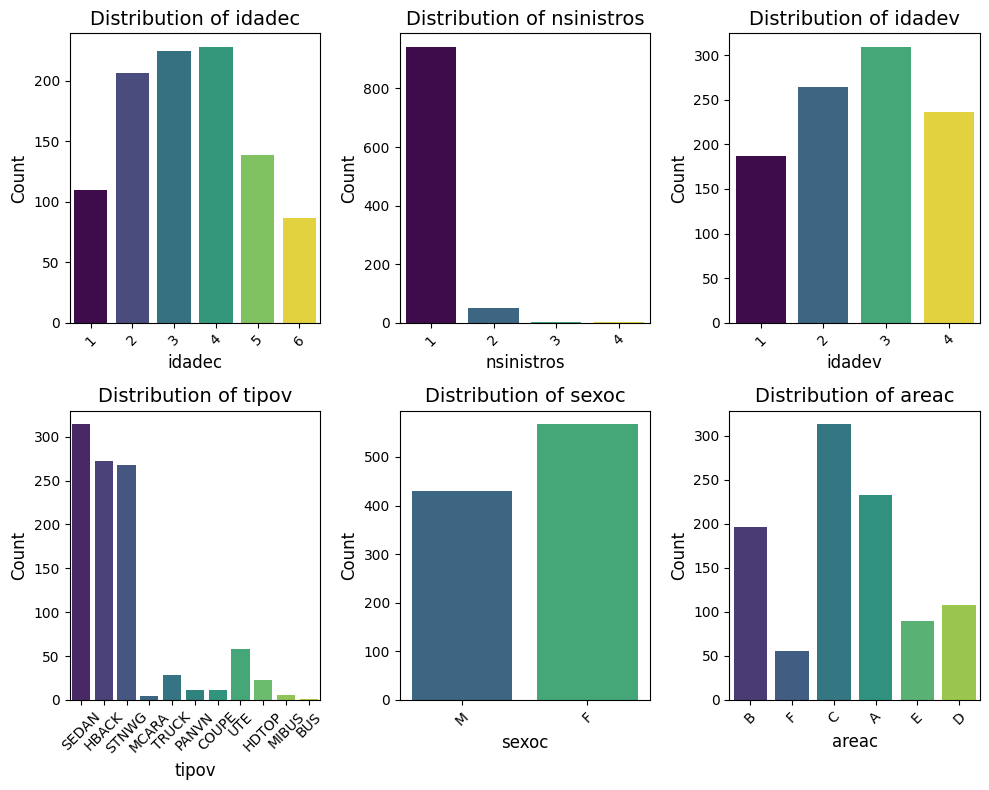

In [6]:
def categorical_var_plots(df, var_names, n_cols=2):

    # Comprobar si las varibles existen
    for var in var_names:
        if var not in df.columns:
            raise ValueError(f"Variable '{var}' not found in DataFrame.")

    # Tamaño
    n_rows = (len(var_names) + n_cols - 1) // n_cols  # Número de filas
    plt.figure(figsize=(10, 4 * n_rows))
    
    # Loop por cada variable
    for i, var in enumerate(var_names):
        plt.subplot(n_rows, n_cols, i + 1)  
        sns.countplot(data=df, x=var, hue=var, palette='viridis', legend=False)  # Use hue for color
        plt.title(f'Distribution of {var}', fontsize=14)
        plt.xticks(rotation=45, fontsize=10)
        plt.xlabel(var, fontsize=12)
        plt.ylabel('Count', fontsize=12)
    
    # Ajuste de Layout 
    plt.tight_layout()
    plt.show()

var_names = ('idadec', 'nsinistros', 'idadev', 'tipov', 'sexoc', 'areac')
categorical_var_plots(data, var_names, n_cols=3)

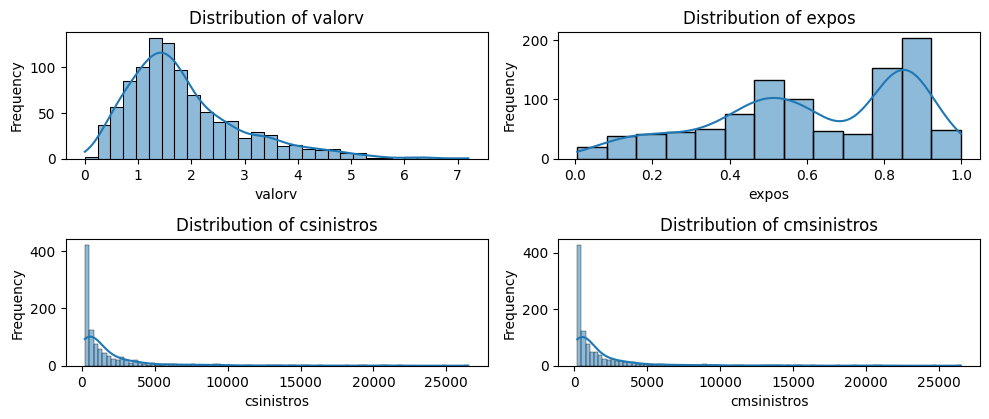

None


In [7]:
def continuos_var_plot(df, var_names, kde=False):
    
    plt.figure(figsize=(10, len(var_names) * 2))
    
    for i, var in enumerate(var_names, 1):
        plt.subplot(len(var_names), 2, i)
        sns.histplot(data=df, x=var, kde=kde)  
        plt.title(f'Distribution of {var}')
        plt.xlabel(var)
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

var_names = ('valorv', 'expos', 'csinistros', 'cmsinistros')
result = continuos_var_plot(data, var_names, kde=True)  
print(result)

- `valorv`: distribución asimétrica, la mayoría de los valores se concentran entre 0 y 3 (miles de dólares).
- `expos`: inversamente proporcional con `valorv`,cuanto mayor es la exposición, menor es el valor.
- `csinistros`: distribución decreciente, con la mayoría de los valores cercanos a 0 , esencial para evaluar los coches usados.
- `cmsinistros`: sigue una distribución similar a la de `csinistros`, ya que es un derivado directo.


## Preparación de Datos

In [8]:
# Valores de variables categoricas
print(data['tipov'].unique())
print(data['areac'].unique())
print(data['idadec'].unique())


['SEDAN' 'HBACK' 'STNWG' 'MCARA' 'TRUCK' 'PANVN' 'COUPE' 'UTE' 'HDTOP'
 'MIBUS' 'BUS']
['B' 'F' 'C' 'A' 'E' 'D']
[6 4 2 3 5 1]


In [9]:
# Mappings para reducción de dimensionalidad de variables categoria
mapping_tipov = {
    'SEDAN': 'COCHE_PASAJEROS',
    'HBACK': 'COCHE_PASAJEROS',
    'COUPE': 'COCHE_PASAJEROS',
    'MCARA': 'COCHE_PASAJEROS',
    'TRUCK': 'VEHICULO_CARGA',
    'UTE': 'VEHICULO_CARGA',
    'STNWG': 'VEHICULO_CARGA',
    'PANVN': 'VAN_BUS',
    'MIBUS': 'VAN_BUS',
    'BUS': 'VAN_BUS',
    'HDTOP': 'OTROS'
}

mapping_areac = {
    'A':'1',
    'B':'1',
    'C': '2',
    'D': '2',
    'E':'3',
    'F': '3',

}

def map_idade(idade):
    if idade <=2:
        return 'JOVEN'
    if idade <=5:
        return 'ADULTO'
    else:
        return 'SENIOR'


# Aplicar los mappings
df_c = data.copy()
df_c['tipov'] = df_c['tipov'].map(mapping_tipov)
df_c['areac'] = df_c['areac'].map(mapping_areac)
df_c['idadec'] = df_c['idadec'].apply(map_idade)
    


In [10]:
# Aplicar los mappings
df_c = data.copy()
df_c['tipov'] = df_c['tipov'].map(mapping_tipov)
df_c['areac'] = df_c['areac'].map(mapping_areac)
df_c['idadec'] = df_c['idadec'].apply(map_idade)
    

In [11]:
df_c.head()

,valorv,expos,nsinistros,csinistros,tipov,idadev,sexoc,areac,idadec,cmsinistros
0,1.66,0.484600,1,669.509999,COCHE_PASAJEROS,3,M,1,SENIOR,669.509999
1,1.51,0.993840,1,806.609999,COCHE_PASAJEROS,3,F,3,ADULTO,806.609999
2,0.76,0.539357,1,401.805451,COCHE_PASAJEROS,3,M,2,ADULTO,401.805451
3,1.89,0.654346,2,1811.709997,VEHICULO_CARGA,3,M,3,JOVEN,905.854999
4,4.06,0.851472,1,5434.439987,VEHICULO_CARGA,2,M,3,ADULTO,5434.439987


In [12]:
summary_df = column_summary(df_c)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,valorv,float64,0,996,353,"{1.37: 11, 1.65: 10, 1.26: 10, 1.97: 9, 0.44: ..."
1,expos,float64,0,996,304,"{0.9993155373: 27, 0.900752909: 14, 0.86516084..."
2,nsinistros,int64,0,996,4,"{1: 941, 2: 50, 3: 4, 4: 1}"
3,csinistros,float64,0,996,705,"{200.0: 161, 353.76999998: 48, 389.94999981: 1..."
4,tipov,object,0,996,4,"{'COCHE_PASAJEROS': 601, 'VEHICULO_CARGA': 354..."
5,idadev,int64,0,996,4,"{3: 309, 2: 264, 4: 236, 1: 187}"
6,sexoc,object,0,996,2,"{'F': 567, 'M': 429}"
7,areac,object,0,996,3,"{'1': 429, '2': 421, '3': 146}"
8,idadec,object,0,996,3,"{'ADULTO': 592, 'JOVEN': 317, 'SENIOR': 87}"
9,cmsinistros,float64,0,996,704,"{200.0: 163, 353.76999998: 48, 389.94999981: 1..."


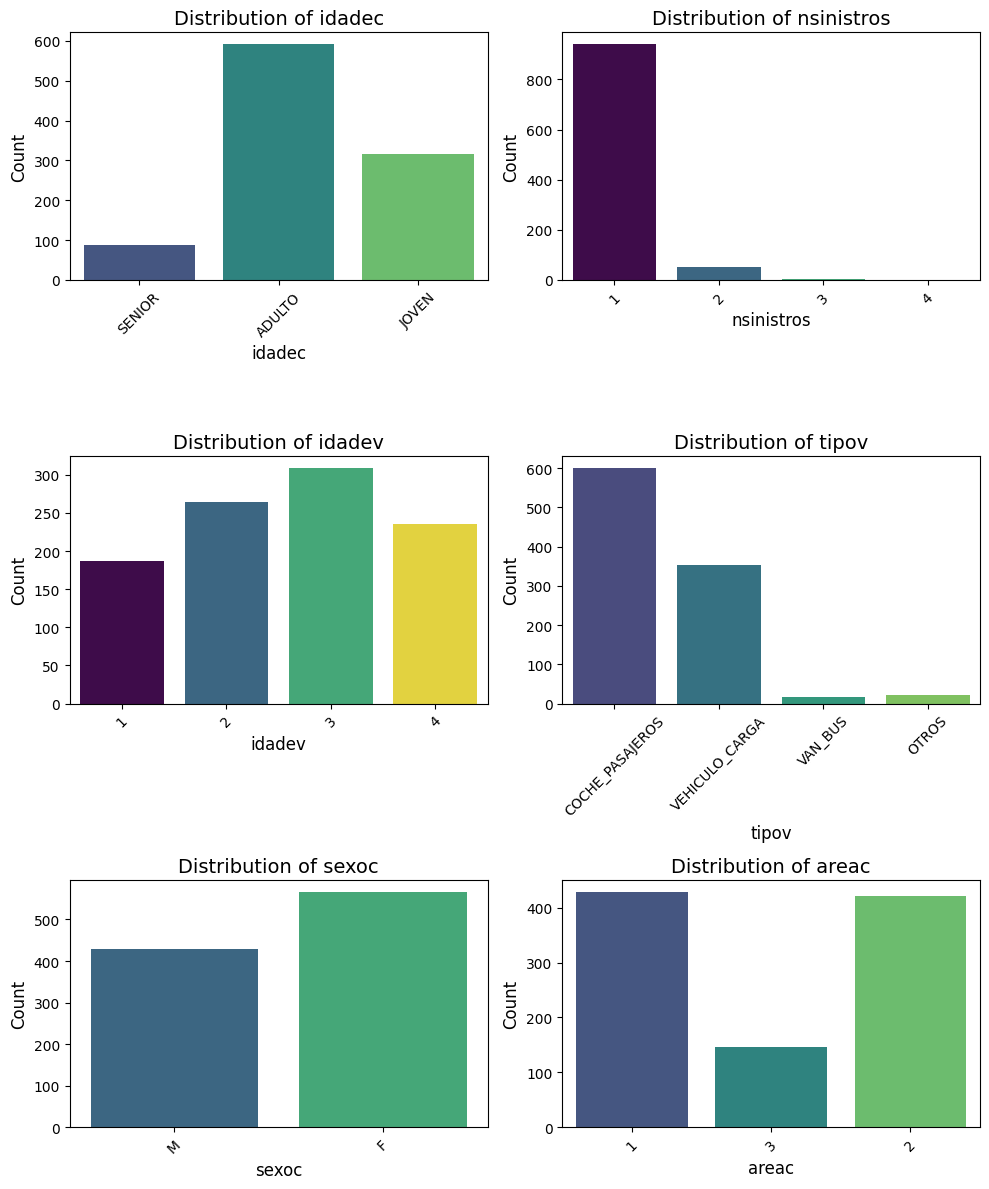

In [13]:
var_names = ('idadec', 'nsinistros','idadev', 'tipov', 'sexoc','areac')
categorical_var_plots(df_c, var_names)

In [14]:
# Gráfico de correlación
# Variable `tipov`
def string_to_factor(df,var):
    # Indices tienen que ser strings or slices, si el input es una lista de string se necesits enumerate()
    for i, var in enumerate(var,1): 
        df[var] = pd.factorize(df[var])[0]
    
var = ('tipov','areac','sexoc','idadec') 
string_to_factor(df_c,var)

Text(0.5, 1.0, 'Variable correlation plot')

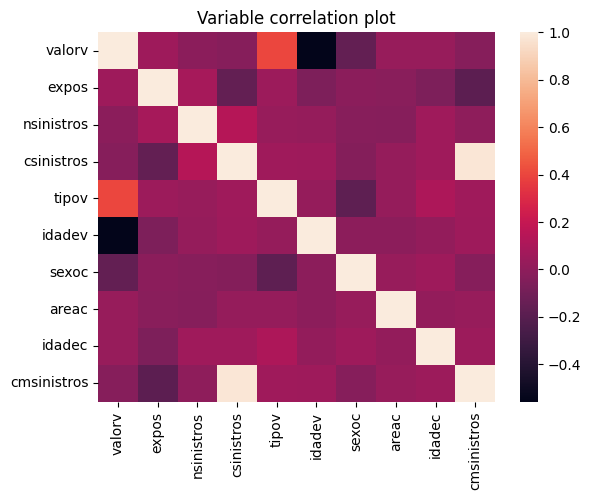

In [15]:
corr_matrix = df_c.corr()
sns.heatmap(corr_matrix)
plt.title('Variable correlation plot')


In [16]:
corr_matrix['cmsinistros']

valorv        -0.030907
expos         -0.182763
nsinistros    -0.000354
csinistros     0.976648
tipov          0.057786
idadev         0.053990
sexoc         -0.034340
areac          0.026502
idadec         0.046093
cmsinistros    1.000000
Name: cmsinistros, dtype: float64

- Las variables presentan baja correlación

## Modelo Gamma

In [17]:
## Modelo Inicial ##

# Función para creación modelo_gamma con target 'cmsinistros'
def modelos_gamma(df, features):
    target = 'cmsinistros'
    
    X = df[list(features)]
    y = df[target]
    X = sm.add_constant(X)  # Agregar constante para el modelo
    model = sm.GLM(y, X, family=sm.families.Gamma())
    
    
    result = model.fit()
    r_squared = 1 - (result.deviance / result.null_deviance)
    print(result.summary())
    print(f'R_squared: {r_squared}')
    return r_squared and result

   



In [18]:
# Variables escogidas de manera 'aleatoria'
features = ['idadec', 'tipov', 'idadev', 'areac', 'expos']
modelos_gamma(df_c,features)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            cmsinistros   No. Observations:                  996
Model:                            GLM   Df Residuals:                      990
Model Family:                   Gamma   Df Model:                            5
Link Function:           InversePower   Scale:                          2.2274
Method:                          IRLS   Log-Likelihood:                -8528.4
Date:                Wed, 12 Mar 2025   Deviance:                       1675.9
Time:                        22:07:00   Pearson chi2:                 2.21e+03
No. Iterations:                     9   Pseudo R-squ. (CS):           -0.07616
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005   9.79e-05      5.032      0.0

C:\Users\BlackMarrow PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [19]:
from itertools import combinations
# Posibles combinaciones de variables (Combinación de C(7,5))
new_features = ['expos','idadec', 'idadev', 'tipov', 'areac','valorv','sexoc']

comb = list(combinations(new_features,5))

posibles_comb = pd.DataFrame(comb, columns = ['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5'])
print(posibles_comb)


   Feature1 Feature2 Feature3 Feature4 Feature5
0     expos   idadec   idadev    tipov    areac
1     expos   idadec   idadev    tipov   valorv
2     expos   idadec   idadev    tipov    sexoc
3     expos   idadec   idadev    areac   valorv
4     expos   idadec   idadev    areac    sexoc
5     expos   idadec   idadev   valorv    sexoc
6     expos   idadec    tipov    areac   valorv
7     expos   idadec    tipov    areac    sexoc
8     expos   idadec    tipov   valorv    sexoc
9     expos   idadec    areac   valorv    sexoc
10    expos   idadev    tipov    areac   valorv
11    expos   idadev    tipov    areac    sexoc
12    expos   idadev    tipov   valorv    sexoc
13    expos   idadev    areac   valorv    sexoc
14    expos    tipov    areac   valorv    sexoc
15   idadec   idadev    tipov    areac   valorv
16   idadec   idadev    tipov    areac    sexoc
17   idadec   idadev    tipov   valorv    sexoc
18   idadec   idadev    areac   valorv    sexoc
19   idadec    tipov    areac   valorv  

In [20]:
# Ajustar el modelo gamma
# Repetimos la misma funcion pero sin que haga print (evitar tantos resultados)
def model_gamma(df, features):
    target = 'cmsinistros'
    
    X = df[list(features)]
    y = df[target]
    X = sm.add_constant(X)  # Agregar constante para el modelo
    model = sm.GLM(y, X, family=sm.families.Gamma())
    
    
    result = model.fit()
    r_squared = 1 - (result.deviance / result.null_deviance)
    return r_squared
    

# Almacenar los resultados
results = []

# Probar cada combinación de características
for index, row in posibles_comb.iterrows():
    features = row.values
    r_squared = model_gamma(df_c, features)
    if r_squared is not None:
        results.append((features, r_squared))

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results, columns=['Features', 'R-squared'])

# Seleccionar las 3 combinaciones con mayor R-squared
top_3 = results_df.nlargest(3, 'R-squared')

# Mostrar los resultados
print(top_3)

C:\Users\BlackMarrow PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\BlackMarrow PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\BlackMarrow PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain 

                                 Features  R-squared
4   [expos, idadec, idadev, areac, sexoc]   0.067636
5  [expos, idadec, idadev, valorv, sexoc]   0.066681
9   [expos, idadec, areac, valorv, sexoc]   0.066158


C:\Users\BlackMarrow PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
C:\Users\BlackMarrow PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


| Features                                      | R-squared |
|-----------------------------------------------|-----------|
| [expos, idadec, idadev, areac, sexoc]       | 0.067636  |
| [expos, idadec, idadev, valorv, sexoc]      | 0.066681  |
| [expos, idadec, areac, valorv, sexoc]       | 0.066158  |

In [21]:
# Antes de ajustar el modelo final, por curiosidad probamos con las 3 variables mas repetidas
features = ['expos','idadec', 'idadev']
modelos_gamma(df_c, features)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            cmsinistros   No. Observations:                  996
Model:                            GLM   Df Residuals:                      992
Model Family:                   Gamma   Df Model:                            3
Link Function:           InversePower   Scale:                          2.2925
Method:                          IRLS   Log-Likelihood:                -8479.7
Date:                Wed, 12 Mar 2025   Deviance:                       1416.8
Time:                        22:07:01   Pearson chi2:                 2.27e+03
No. Iterations:                     9   Pseudo R-squ. (CS):            0.04142
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      3.797      0.0

C:\Users\BlackMarrow PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


- Realiza un peor ajuste, elegimos el otro modelo.

In [22]:
# Final Model
features = ['expos','idadec', 'idadev','areac', 'sexoc']  
fit_model = modelos_gamma(df_c,features)


C:\Users\BlackMarrow PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:            cmsinistros   No. Observations:                  996
Model:                            GLM   Df Residuals:                      990
Model Family:                   Gamma   Df Model:                            5
Link Function:           InversePower   Scale:                          2.2726
Method:                          IRLS   Log-Likelihood:                -8475.5
Date:                Wed, 12 Mar 2025   Deviance:                       1411.1
Time:                        22:07:01   Pearson chi2:                 2.25e+03
No. Iterations:                    10   Pseudo R-squ. (CS):            0.04422
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      3.569      0.0

In [23]:
# Funciones para gráficas de diagnostico
def calculate_hat_matrix(X: np.ndarray, weights: Optional[np.ndarray] = None) -> np.ndarray:

    if weights is None:
        weights = np.ones(len(X))
    W = np.diag(weights)
    return X @ np.linalg.inv(X.T @ W @ X) @ X.T @ W

def simulate_envelopes(n_points: int, n_sim: int = 100) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:

    sim_res = np.zeros((n_sim, n_points))
    
    for i in range(n_sim):
        z = np.random.normal(size=n_points)
        sim_res[i,:] = np.sort(z)
    
    lower = np.percentile(sim_res, 2.5, axis=0)
    upper = np.percentile(sim_res, 97.5, axis=0)
    median = np.median(sim_res, axis=0)
    
    return lower, median, upper

def diagnostic_plots(
    fit_model: Any,
    data: pd.DataFrame,
    fig_size: Tuple[int, int] = (15, 10),
    n_sim: int = 100
) -> None:

    # Extraer componentes del modelo
    X = fit_model.model.exog
    weights = fit_model.model.weights if fit_model.model.weights is not None else np.ones(len(X))
    
    # Calcular diagnostico
    H = calculate_hat_matrix(X, weights)
    h = np.diag(H)
    res = fit_model.resid_pearson
    std_res = res / np.sqrt(1 - h)
    fitted = fit_model.fittedvalues
    
    # Calcular distacnia de Cook's
    p = X.shape[1]
    cooks_d = (res**2 * h) / (p * (1 - h)**2)
    
    # Crear subplot layout
    fig, axes = plt.subplots(2, 2, figsize=fig_size)
    fig.suptitle('Gamma Regression Diagnostic Plots', fontsize=16, y=1.02)
    
    # 1. Normal Q-Q Plot con envelope
    theo_q = stats.norm.ppf(np.arange(1, len(res) + 1) / (len(res) + 1))
    ord_res = np.sort(std_res)
    lower, median, upper = simulate_envelopes(len(res), n_sim)
    
    axes[0,0].plot(theo_q, ord_res, 'ko', label='Observed', alpha=0.5)
    axes[0,0].plot(theo_q, median, 'r-', label='Median')
    axes[0,0].plot(theo_q, lower, 'r--', label='95% Confidence Band')
    axes[0,0].plot(theo_q, upper, 'r--')
    axes[0,0].plot(theo_q, theo_q, 'b-', label='Reference Line')
    axes[0,0].set_xlabel('Theoretical Quantiles')
    axes[0,0].set_ylabel('Sample Quantiles')
    axes[0,0].set_title('Normal Q-Q Plot')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Residuos vs Fitted
    axes[0,1].scatter(fitted, std_res, alpha=0.5)
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Fitted values')
    axes[0,1].set_ylabel('Standardized residuals')
    axes[0,1].set_title('Residuals vs Fitted')
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Scale-Location Plot
    axes[1,0].scatter(fitted, np.sqrt(np.abs(std_res)), alpha=0.5)
    axes[1,0].set_xlabel('Fitted values')
    axes[1,0].set_ylabel('√|Standardized residuals|')
    axes[1,0].set_title('Scale-Location Plot')
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Distacnia de Cook's 
    influential = cooks_d > (4 / len(res))
    axes[1,1].scatter(range(len(res)), cooks_d, alpha=0.5)
    axes[1,1].scatter(np.where(influential)[0], cooks_d[influential], 
                     color='red', alpha=0.5, label='Influential')
    axes[1,1].axhline(y=4/len(res), color='r', linestyle='--', 
                      label='Threshold (4/n)')
    axes[1,1].set_xlabel('Observation index')
    axes[1,1].set_ylabel("Cook's distance")
    axes[1,1].set_title("Cook's Distance Plot")
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Puntos Influyentes
    if np.any(influential):
        print("\nInfluential observations detected:")
        print(f"Indices: {np.where(influential)[0]}")
        print(f"Cook's distances: {cooks_d[influential].round(4)}")
    
    return influential

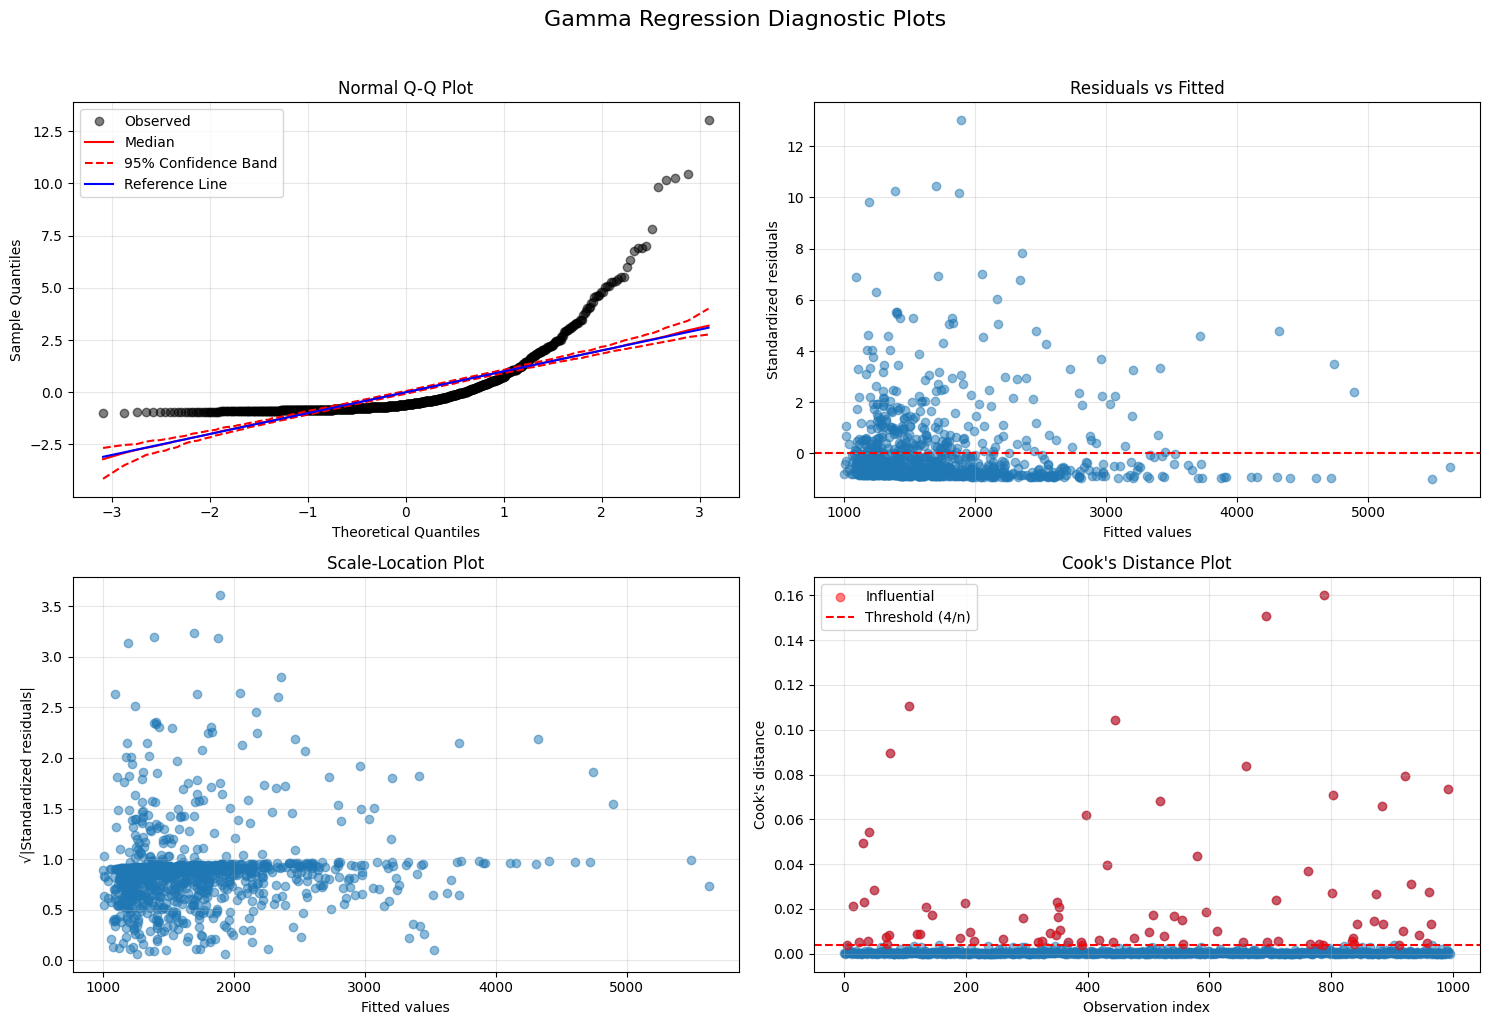


Influential observations detected:
Indices: [  4  15  25  31  33  39  41  49  69  71  74  75 106 119 124 134 145 190
 198 206 214 261 293 318 325 338 348 349 352 353 354 367 389 391 398 418
 432 441 445 476 500 507 519 526 542 555 557 579 594 613 656 661 693 694
 710 713 762 765 780 787 788 801 804 834 836 838 842 871 874 883 886 912
 918 921 932 944 957 961 965 992]
Cook's distances: 4      0.0041
15     0.0212
25     0.0052
31     0.0493
33     0.0231
        ...  
944    0.0083
957    0.0049
961    0.0278
965    0.0133
992    0.0734
Length: 80, dtype: float64


0      False
1      False
2      False
3      False
4       True
       ...  
991    False
992     True
993    False
994    False
995    False
Length: 996, dtype: bool

In [24]:
diagnostic_plots(fit_model, df_c)

In [25]:
# ¿Que ocurre si eliminamos todos los puntos influyentes?
influential = [  4,  15, 25, 31, 33, 39, 41, 49, 69, 71, 74, 75, 106, 
               119, 124, 134, 145, 190, 198, 206, 214, 261, 293, 318, 
               325, 338, 348, 349, 352, 353, 354, 367, 389, 391, 398, 
               418, 432, 441, 445, 476, 500, 507, 519, 526, 542, 555, 
               557, 579, 594, 613, 656, 661, 693, 694, 710, 713, 762, 
               765, 780, 787, 788, 801, 804, 834, 836, 838, 842, 871, 
               874, 883, 886, 912, 918, 921, 932, 944, 957, 961, 965, 
               992]

df_influential = df_c.copy()
df_influential = df_influential.drop(influential)

In [26]:
features = ['expos','idadec', 'idadev','areac', 'sexoc'] 
modelos_gamma(df_influential,features)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            cmsinistros   No. Observations:                  916
Model:                            GLM   Df Residuals:                      910
Model Family:                   Gamma   Df Model:                            5
Link Function:           InversePower   Scale:                          1.0653
Method:                          IRLS   Log-Likelihood:                -7315.0
Date:                Wed, 12 Mar 2025   Deviance:                       836.44
Time:                        22:07:03   Pearson chi2:                     969.
No. Iterations:                     8   Pseudo R-squ. (CS):            0.01683
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      7.432      0.0

C:\Users\BlackMarrow PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


- Realiza un peor ajuste, nos quedamos con el modelo final.

## Modelo Normal 

In [27]:
# Modelo Normal
def modelo_norm(df,features):
    target = 'cmsinistros'

    X = df[features]
    y = df[target]
    X = sm.add_constant(X)

    model = sm.GLM(y, X, family = sm.families.Gaussian())
    result = model.fit()
    r_squared = (1 - (result.deviance / result.null_deviance))
      
    print(result.summary())
    print(f'R_squared: {r_squared}')
    return r_squared and result





- Probamos a ajustar el modelo de forma inicial con los feautres que mejoran el modelo gamma para comprobar si coinciden con las features que mejor ajustan el modelo normal.

In [28]:
# Features mejores para modelo gamma 
features = ['expos','idadec', 'idadev','areac', 'sexoc'] 
fit_model_norm = modelo_norm(df_c,features)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            cmsinistros   No. Observations:                  996
Model:                            GLM   Df Residuals:                      990
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                      8.4221e+06
Method:                          IRLS   Log-Likelihood:                -9351.5
Date:                Wed, 12 Mar 2025   Deviance:                   8.3379e+09
Time:                        22:07:03   Pearson chi2:                 8.34e+09
No. Iterations:                     3   Pseudo R-squ. (CS):            0.03900
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2529.1067    420.897      6.009      0.0

In [29]:
def regression_diagnostics(fit_model, figsize=(12, 10)):

    # Extraer los componentes del model
    X = fit_model.model.exog
    n = X.shape[0]  # numero de observaciones
    p = X.shape[1]  # numero de parametros
    
    # Calcular hat matrix (H)
    H = X @ np.linalg.inv(X.T @ X) @ X.T
    h = np.diag(H)  # leverage values
    
    # Residuos y otros componentes
    r = fit_model.resid_pearson  # pearson residuals for GLM
    sigma = np.sqrt(fit_model.scale)  # scale parameter
    
    # Calcular  residuos estandarizados
    ts = r / np.sqrt(1 - h)
    
    # Calcular la distancia de Cook's distance
    di = (1/p) * (h/(1-h)) * (ts**2)
    
    # Layout de Plots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('GLM Regression Diagnostics', fontsize=14)
    
    # Plot 1: Valores de Leverage 
    axes[0,0].plot(range(n), h, 'ko', markersize=6)
    axes[0,0].axhline(y=2*p/n, color='r', linestyle='--', label='Cutoff (2p/n)')
    axes[0,0].set_xlabel('Index')
    axes[0,0].set_ylabel('Leverage (h)')
    axes[0,0].set_title('Leverage Plot')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Dsitancia de Cook's 
    axes[0,1].plot(range(n), di, 'ko', markersize=6)
    axes[0,1].set_xlabel('Index')
    axes[0,1].set_ylabel("Cook's Distance")
    axes[0,1].set_title("Cook's Distance Plot")
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Residuos estandarizados vs Index
    axes[1,0].plot(range(n), ts, 'ko', markersize=6)
    axes[1,0].axhline(y=2, color='r', linestyle='--', label='±2 threshold')
    axes[1,0].axhline(y=-2, color='r', linestyle='--')
    axes[1,0].set_xlabel('Index')
    axes[1,0].set_ylabel('Standardized Residuals')
    axes[1,0].set_title('Standardized Residuals vs Index')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Residuos estandarizados vs Fitted values
    fitted_vals = fit_model.fittedvalues
    axes[1,1].plot(fitted_vals, ts, 'ko', markersize=6)
    axes[1,1].axhline(y=2, color='r', linestyle='--', label='±2 threshold')
    axes[1,1].axhline(y=-2, color='r', linestyle='--')
    axes[1,1].set_xlabel('Fitted Values')
    axes[1,1].set_ylabel('Standardized Residuals')
    axes[1,1].set_title('Standardized Residuals vs Fitted')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Puntos influenciales
    print("\nDiagnostic Summary:")
    print(f"Number of high leverage points (h > {2*p/n:.3f}): {np.sum(h > 2*p/n)}")
    print(f"Number of outliers (|std residuals| > 2): {np.sum(np.abs(ts) > 2)}")
    print(f"Number of influential points (Cook's D > {4/n:.3f}): {np.sum(di > 4/n)}")
    
    # Valores del diagnostico
    return {
        'leverage': h,
        'cooks_distance': di,
        'std_residuals': ts,
        'cutoff_leverage': 2*p/n,
        'high_leverage': h > 2*p/n,
        'influential_points': di > 4/n,
        'outliers': np.abs(ts) > 2
    }

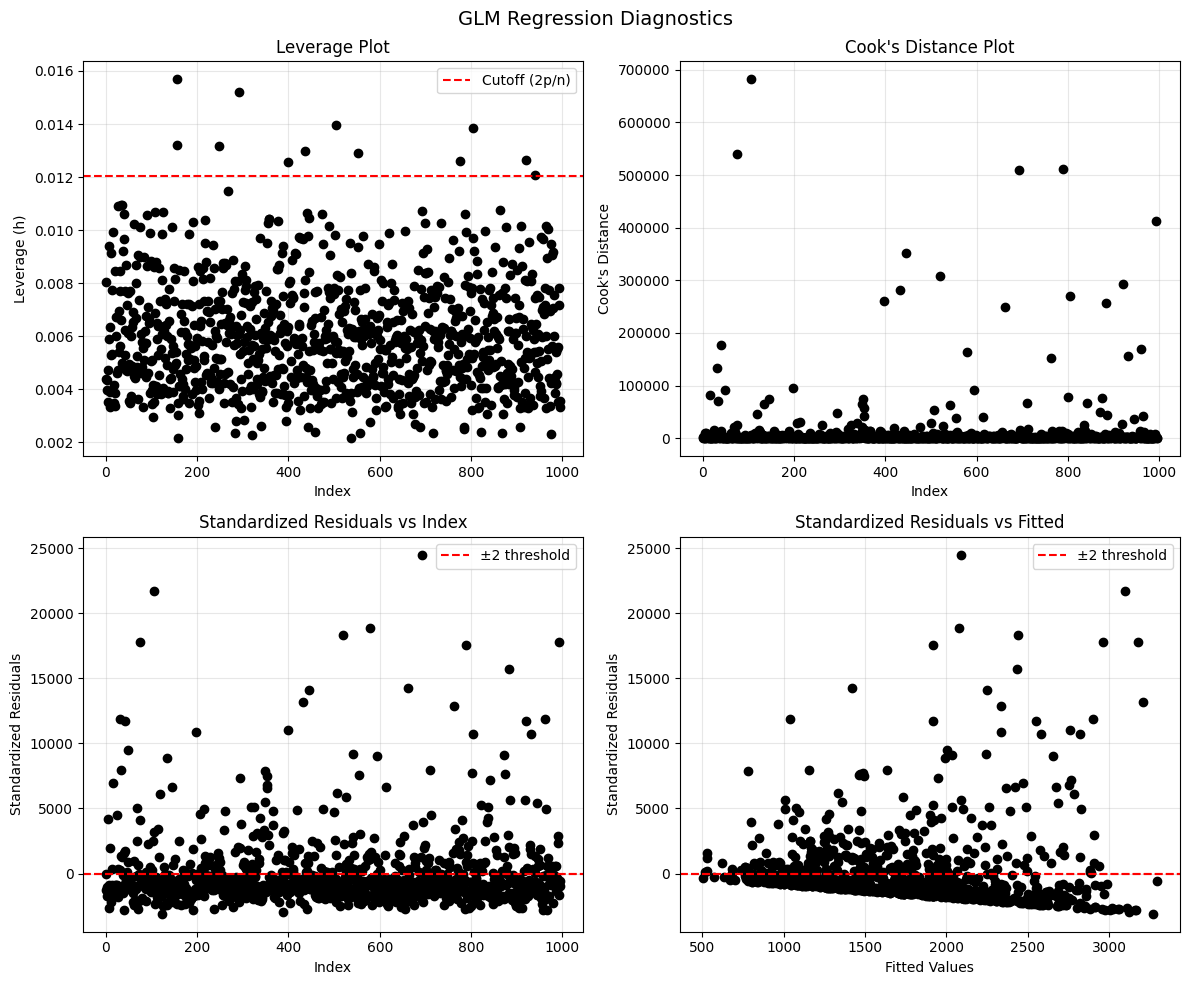


Diagnostic Summary:
Number of high leverage points (h > 0.012): 12
Number of outliers (|std residuals| > 2): 996
Number of influential points (Cook's D > 0.004): 996


{'leverage': array([0.00803897, 0.00439475, 0.00395953, 0.00436536, 0.00352248,
        0.00471237, 0.00590537, 0.00941334, 0.00634546, 0.00389529,
        0.00332818, 0.00912411, 0.00530599, 0.00773453, 0.00532106,
        0.0099122 , 0.00341777, 0.00347288, 0.0041664 , 0.00336928,
        0.00844827, 0.00385821, 0.00673418, 0.00602625, 0.00673418,
        0.00459949, 0.00474557, 0.01092565, 0.00539913, 0.00695907,
        0.00772157, 0.00564467, 0.00846422, 0.00662245, 0.01096512,
        0.00499321, 0.0109406 , 0.00486654, 0.00919573, 0.00964999,
        0.01061162, 0.00768907, 0.00527797, 0.00623212, 0.00869638,
        0.00472425, 0.00470399, 0.00718498, 0.00761977, 0.00612327,
        0.00497021, 0.00355808, 0.0034704 , 0.0077183 , 0.00375512,
        0.00359592, 0.00600289, 0.00633546, 0.00489291, 0.00653069,
        0.00692681, 0.01024053, 0.00449048, 0.00442647, 0.0045982 ,
        0.00668944, 0.00867388, 0.00801182, 0.00526975, 0.00483046,
        0.00361831, 0.00907949, 0.00

In [30]:
regression_diagnostics(fit_model_norm)

In [31]:
# Ajustar el modelo gamma
# Repetimos la misma funcion pero sin que haga print (evitar tantos resultados)
def model_normal(df, features):
    target = 'cmsinistros'
    
    X = df[list(features)]
    y = df[target]
    X = sm.add_constant(X)  # Agregar constante para el modelo
    model = sm.GLM(y, X, family=sm.families.Gaussian())
    
    
    result = model.fit()
    r_squared = 1 - (result.deviance / result.null_deviance)
    return r_squared
    

# Almacenar los resultados
results = []

# Probar cada combinación de características
for index, row in posibles_comb.iterrows():
    features = row.values
    r_squared = model_normal(df_c, features)
    if r_squared is not None:
        results.append((features, r_squared))

# Convertir los resultados a un DataFrame
results_df = pd.DataFrame(results, columns=['Features', 'R-squared'])

# Seleccionar las 3 combinaciones con mayor R-squared
top_3 = results_df.nlargest(3, 'R-squared')

# Mostrar los resultados
print(top_3)

                                 Features  R-squared
8   [expos, idadec, tipov, valorv, sexoc]   0.042296
14   [expos, tipov, areac, valorv, sexoc]   0.042017
6   [expos, idadec, tipov, areac, valorv]   0.041716


In [32]:
# Comparación de las features que mejoran cada modelo
features_gamma = ['expos','idadec', 'idadev','areac', 'sexoc'] 
features_normal = ['expos','idadec', 'tipov','valorv', 'sexoc'] 



In [33]:
final_fit_model_norm = modelo_norm(df_c, features_normal)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            cmsinistros   No. Observations:                  996
Model:                            GLM   Df Residuals:                      990
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                      8.3886e+06
Method:                          IRLS   Log-Likelihood:                -9349.6
Date:                Wed, 12 Mar 2025   Deviance:                   8.3047e+09
Time:                        22:07:06   Pearson chi2:                 8.30e+09
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04297
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3096.8922    365.708      8.468      0.0

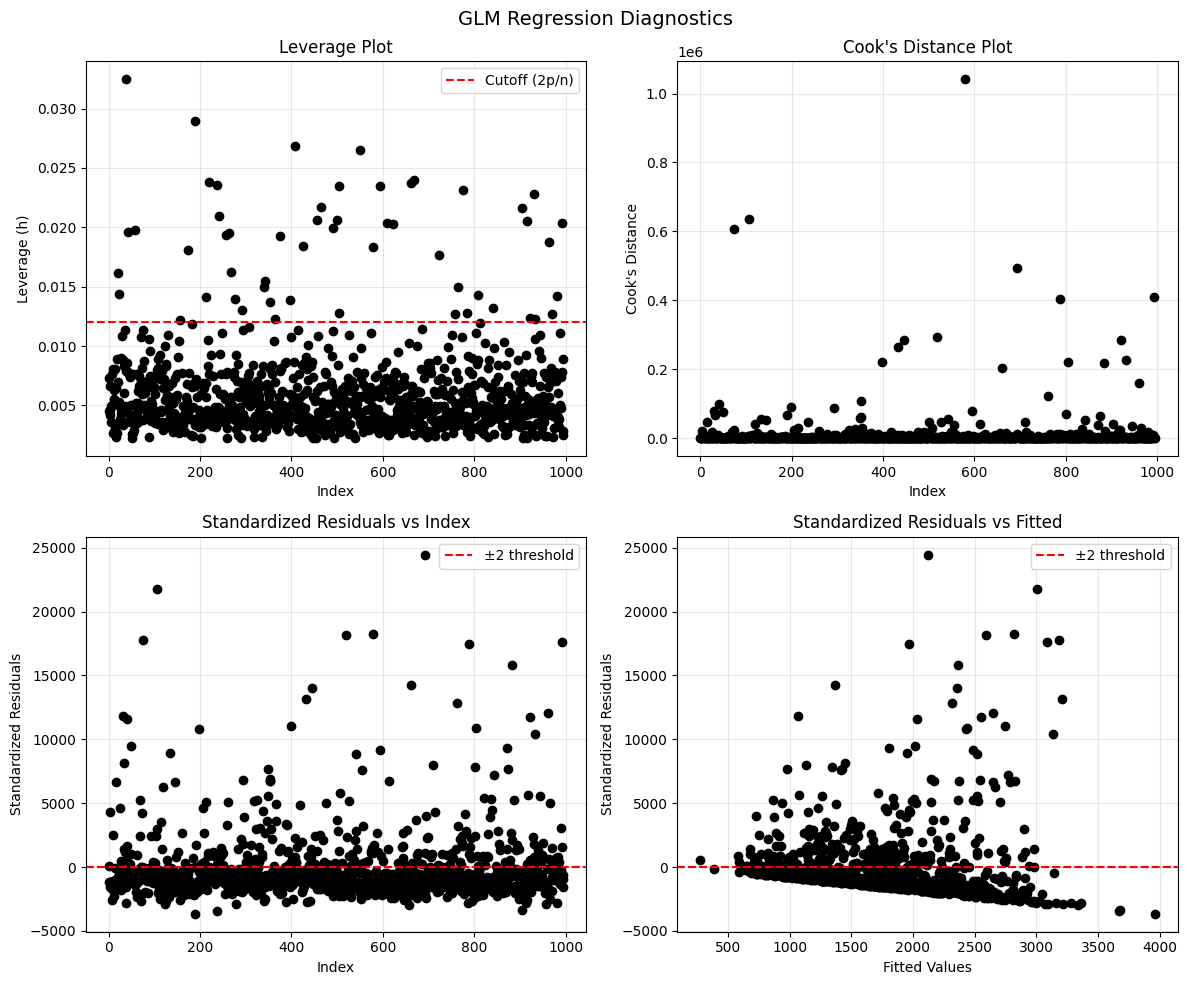


Diagnostic Summary:
Number of high leverage points (h > 0.012): 54
Number of outliers (|std residuals| > 2): 995
Number of influential points (Cook's D > 0.004): 996


{'leverage': array([0.00727557, 0.0045093 , 0.00416738, 0.00463615, 0.00663102,
        0.00357717, 0.00498042, 0.00762143, 0.00499303, 0.00805199,
        0.00270348, 0.00627854, 0.0055231 , 0.00808235, 0.00307649,
        0.00644551, 0.00236999, 0.00342345, 0.0089343 , 0.0026714 ,
        0.01612374, 0.00699002, 0.01437894, 0.00526189, 0.00386506,
        0.00487979, 0.00434292, 0.00898783, 0.00497026, 0.00461194,
        0.0108098 , 0.0033727 , 0.00882757, 0.0060098 , 0.0083383 ,
        0.00497308, 0.011309  , 0.00446433, 0.03246771, 0.00792779,
        0.00859787, 0.00440571, 0.01962643, 0.00778452, 0.00766409,
        0.00378129, 0.00361934, 0.0074064 , 0.00756536, 0.00500613,
        0.00419568, 0.00260662, 0.00225605, 0.00767994, 0.00270079,
        0.00291365, 0.00407309, 0.01975759, 0.00496641, 0.00418123,
        0.0051988 , 0.00763326, 0.00347451, 0.00409755, 0.00516219,
        0.00620373, 0.00751461, 0.00659742, 0.00466106, 0.00374689,
        0.01073595, 0.00705792, 0.00

In [34]:
regression_diagnostics(final_fit_model_norm)

## Modelos Finales

In [35]:
features_gamma = ['expos','idadec', 'idadev','areac', 'sexoc'] 
final_fit_model_gamma = modelos_gamma(df_c, features_gamma)


                 Generalized Linear Model Regression Results                  
Dep. Variable:            cmsinistros   No. Observations:                  996
Model:                            GLM   Df Residuals:                      990
Model Family:                   Gamma   Df Model:                            5
Link Function:           InversePower   Scale:                          2.2726
Method:                          IRLS   Log-Likelihood:                -8475.5
Date:                Wed, 12 Mar 2025   Deviance:                       1411.1
Time:                        22:07:07   Pearson chi2:                 2.25e+03
No. Iterations:                    10   Pseudo R-squ. (CS):            0.04422
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      3.569      0.0

C:\Users\BlackMarrow PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [36]:
features_normal = ['expos','idadec', 'tipov','valorv', 'sexoc'] 
final_fit_model_norm = modelo_norm(df_c, features_normal)

                 Generalized Linear Model Regression Results                  
Dep. Variable:            cmsinistros   No. Observations:                  996
Model:                            GLM   Df Residuals:                      990
Model Family:                Gaussian   Df Model:                            5
Link Function:               Identity   Scale:                      8.3886e+06
Method:                          IRLS   Log-Likelihood:                -9349.6
Date:                Wed, 12 Mar 2025   Deviance:                   8.3047e+09
Time:                        22:07:07   Pearson chi2:                 8.30e+09
No. Iterations:                     3   Pseudo R-squ. (CS):            0.04297
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3096.8922    365.708      8.468      0.0

El modelo gamma hace un mejor ajuste de los datos en general.Aunque el ajuste es moderado, aún se podría realizar la exploración de modelos alernativos en búqueda de un mejor ajuste. Quizas explorando modelos no lineales, que capten mejor la relación intrínseca de los datos.
